In [1]:
%matplotlib inline
from sagemaker import get_execution_role
from sagemaker.session import Session
role = get_execution_role()
bucket = Session().default_bucket()

In [2]:
%%time
import pickle, gzip, boto3, json

region = boto3.Session().region_name
boto3.Session().resource('s3', region_name = region).Bucket('sagemaker-sample-data-{}'.format(region)).download_file('algorithms/kmeans/mnist/mnist.pkl.gz', 'mnist.pkl.gz')
with gzip.open('mnist.pkl.gz','rb') as f:
    train_set,valid_set,test_set = pickle.load(f, encoding='latin1')

CPU times: user 921 ms, sys: 357 ms, total: 1.28 s
Wall time: 2.66 s


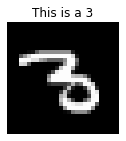

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (2,10)

def show_digit(img, caption= 'Juicy', subplot=None):
    if subplot == None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr,cmap='gray')
    plt.title(caption)
    
show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [5]:
from sagemaker import KMeans
data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to {}'.format(output_location))

kmeans = KMeans(role=role,
               train_instance_count=2,
               train_instance_type='ml.c4.xlarge',
               output_path= output_location,
               k=10,
               data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-east-2-417193079866/kmeans_highlevel_example/data
training artifacts will be uploaded to s3://sagemaker-us-east-2-417193079866/kmeans_example/output


In [6]:
%%time
kmeans.fit(kmeans.record_set(train_set[0]))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-05 07:50:28 Starting - Starting the training job...
2020-11-05 07:50:30 Starting - Launching requested ML instances......
2020-11-05 07:51:53 Starting - Preparing the instances for training.........
2020-11-05 07:53:21 Downloading - Downloading input data...
2020-11-05 07:53:58 Training - Training image download completed. Training in progress.
2020-11-05 07:53:58 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/05/2020 07:53:51 INFO 140623861917504] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_llo

In [ ]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------

In [ ]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

In [ ]:
%%time

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]




Cluster 0


<Figure size 360x0 with 0 Axes>




Cluster 1


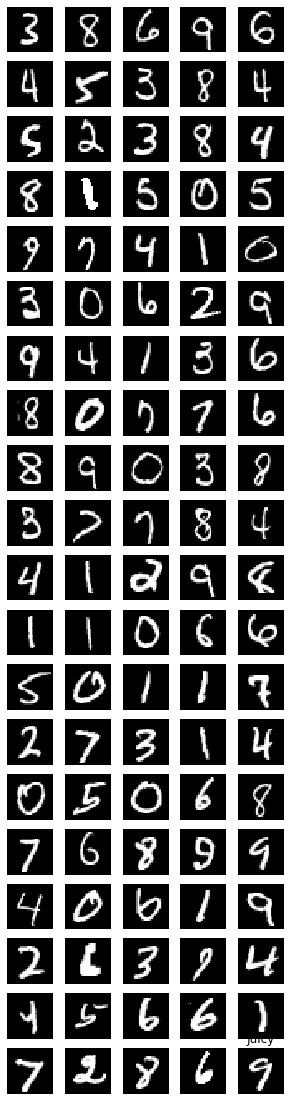

<Figure size 360x0 with 0 Axes>

<Figure size 360x0 with 0 Axes>

<Figure size 360x0 with 0 Axes>

<Figure size 360x0 with 0 Axes>




Cluster 2



Cluster 3



Cluster 4



Cluster 5



Cluster 6


<Figure size 360x0 with 0 Axes>




Cluster 7


<Figure size 360x0 with 0 Axes>




Cluster 8


<Figure size 360x0 with 0 Axes>




Cluster 9


<Figure size 360x0 with 0 Axes>

In [11]:
import numpy
for cluster in range(10):
    print('\n\n\nCluster {}'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters,valid_set[0]) if int(1) == cluster ]
    height = ((len(digits)-1)//5)+1
    width = 5
    plt.rcParams['figure.figsize'] = (width, height)
    _,subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots,digits):
        show_digit(image, subplot = subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
        
    plt.show()

In [12]:
print(kmeans_predictor.endpoint)

kmeans-2020-11-05-07-50-28-182


In [13]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)